In [44]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2

BATCH_SIZE = 8
IMAGE_CHANNEL = 3
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 2000
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 0.001
seed = 1

CUDA = torch.cuda.is_available()
print(f"PyTorch version: {torch.__version__}")
if CUDA:
    print(f"CUDA version: {torch.version.cuda}\n")

torch.cuda.manual_seed(seed)

device = torch.device("cuda" if CUDA else "cpu")
cudnn.benchmark = True 

PyTorch version: 2.1.2
CUDA version: 12.1



In [45]:
def display_data(dataloader,str):
    # Plot some training images
    Data=next(iter(dataloader))
    #print(Data)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data.to(device), nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show() 

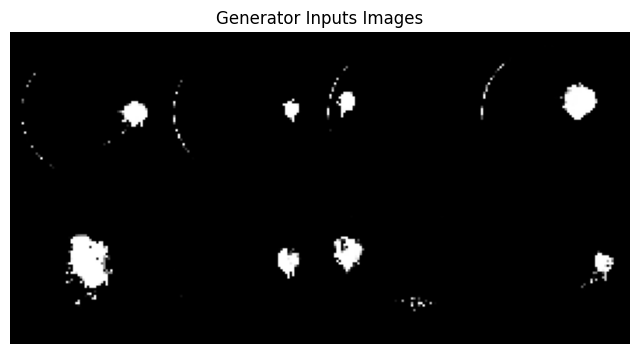

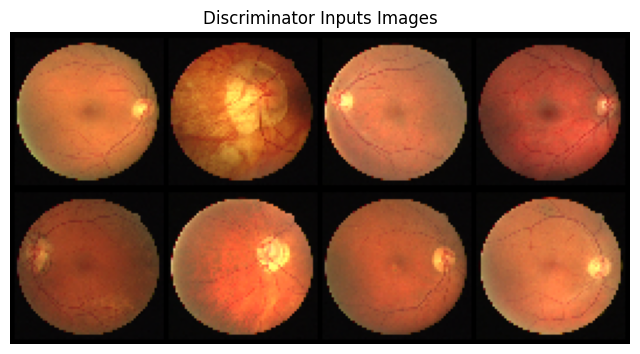

In [46]:
#Dataset for Generator Input Images
transform = transforms.Compose([transforms.ToTensor()])
class vector_Dataset():
    def __init__(self,transform=None):
        self.files=os.listdir('/kaggle/input/gan-major-study-dataset/GAN_Inputs/optic')
        #print(self.files)
        self.file_name=[]
        for file in self.files:
            basename, extension = os.path.splitext(file)
            self.file_name.append(basename)
            
    def __len__(self):
        return(len(self.files))
    
    def __getitem__(self,idx):
        optic=cv2.imread(f'/kaggle/input/gan-major-study-dataset/GAN_Inputs/optic/{self.file_name[idx]}.jpg')
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2GRAY)
        plt.imshow(optic)
        plt.show()
        optic=transform(optic)#.to(device)
        
        return optic

in_dataset=vector_Dataset()

# Dataloader for Generator Input Images
G_inputs = torch.utils.data.DataLoader(in_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)  

#Show Training Images
display_data(G_inputs,'Generator Inputs')

#Dataset for Real Images
transform = transforms.Compose([transforms.ToTensor()])
class training_Dataset():
    def __init__(self,transform=None):
        root_dir=r'/kaggle/input/gan-major-study-dataset/GAN_Inputs/original'
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
            
    def __len__(self):
        return(len(self.image_paths))
    
    def __getitem__(self,idx):
        optic=cv2.imread(self.image_paths[idx])
        optic=cv2.resize(optic,(64,64))
        optic=cv2.cvtColor(optic, cv2.COLOR_BGR2RGB)
        optic=transform(optic)#.to(device)
        
        return optic

train_dataset=training_Dataset()

# Dataloader for Real Images
D_inputs = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#Show Training Images
display_data(D_inputs,'Discriminator Inputs')

In [47]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class downsampler(nn.Module):
    # initializers
    def __init__(self, d=4):
        super(downsampler, self).__init__()
        self.conv1 = nn.Conv2d(1, d,kernel_size=33, stride=1, padding=0)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2,kernel_size=17, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4,kernel_size=9, stride=1, padding=0)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8,kernel_size=8, stride=1, padding=0)
        #self.conv4_bn = nn.BatchNorm2d(d*8)
        self.linear=nn.Linear(32,100).to(device)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        print('shape after Layer1: ',x.shape)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        print('shape after Layer2: ',x.shape)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        print('shape after Layer3: ',x.shape)
        x = self.conv4(x)
        print('shape after Layer4: ',x.shape)  
        x = self.linear(torch.flatten(x, start_dim=1))#, end_dim=2
        print('shape after Linear Layer: ',x.shape)        

        return x
    
# generator and discriminator

class generator(nn.Module):
    # initializers
    def __init__(self, d=G_HIDDEN):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIM, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        #print('Generator Image final size: ',x.shape)

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=D_HIDDEN):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        #self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        #print('Discriminator Image size: ',x.shape)
        
        return x

In [48]:
#create Downsampler instance
Dsmplr = downsampler()
Dsmplr.to(device)
print(Dsmplr)

# Create the generator
netG = generator()
# netG = nn.DataParallel(netG)
netG.to(device)
print(netG)

# Create the discriminator
netD = discriminator()
# netD = nn.DataParallel(netD)
netD.to(device)
print(netD)

for i,data in enumerate(G_inputs,0):
    datapoint = data.to(device)
    print('original shape: ',datapoint.shape)
    tensor=Dsmplr.forward(datapoint)
#print(tensor.shape)

# Reshape to (8, 100, 1, 1)
noise = tensor.view(8, 100, 1, 1)
print('New Input Noise Size: ',noise.shape)
#print(tensor)

downsampler(
  (conv1): Conv2d(1, 4, kernel_size=(33, 33), stride=(1, 1))
  (conv1_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(17, 17), stride=(1, 1))
  (conv2_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1))
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(8, 8), stride=(1, 1))
  (linear): Linear(in_features=32, out_features=100, bias=True)
)
generator(
  (deconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(

Starting Training Loop...
[1/2000][0/1]	Loss_D: 1.7500	Loss_G: 14.7463	D(x): 0.4228	D(G(z)): 0.5831 / 0.0000
[2/2000][0/1]	Loss_D: 7.3098	Loss_G: 11.5952	D(x): 1.0000	D(G(z)): 0.9986 / 0.0006
[3/2000][0/1]	Loss_D: 1.6385	Loss_G: 3.5854	D(x): 0.3136	D(G(z)): 0.1733 / 0.0504
[4/2000][0/1]	Loss_D: 0.9835	Loss_G: 4.1484	D(x): 0.9997	D(G(z)): 0.4706 / 0.0978
[5/2000][0/1]	Loss_D: 0.2238	Loss_G: 4.4135	D(x): 0.9984	D(G(z)): 0.1850 / 0.0554
[6/2000][0/1]	Loss_D: 0.1678	Loss_G: 4.2417	D(x): 0.9881	D(G(z)): 0.1320 / 0.0362
[7/2000][0/1]	Loss_D: 0.2478	Loss_G: 3.7987	D(x): 0.9600	D(G(z)): 0.1590 / 0.0375
[8/2000][0/1]	Loss_D: 0.5678	Loss_G: 4.8199	D(x): 0.9535	D(G(z)): 0.3383 / 0.0236
[9/2000][0/1]	Loss_D: 0.6086	Loss_G: 3.1905	D(x): 0.7108	D(G(z)): 0.1952 / 0.0602
[10/2000][0/1]	Loss_D: 4.2601	Loss_G: 12.8412	D(x): 0.9977	D(G(z)): 0.9515 / 0.0000
[11/2000][0/1]	Loss_D: 5.1173	Loss_G: 8.3888	D(x): 0.0164	D(G(z)): 0.0005 / 0.0017
[12/2000][0/1]	Loss_D: 0.1114	Loss_G: 4.8001	D(x): 0.9174	D(G(z)): 

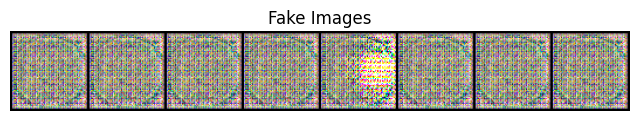

[51/2000][0/1]	Loss_D: 0.0156	Loss_G: 5.1145	D(x): 0.9930	D(G(z)): 0.0085 / 0.0060
[52/2000][0/1]	Loss_D: 0.0214	Loss_G: 4.3865	D(x): 0.9961	D(G(z)): 0.0172 / 0.0134
[53/2000][0/1]	Loss_D: 0.0381	Loss_G: 3.8839	D(x): 0.9980	D(G(z)): 0.0354 / 0.0236
[54/2000][0/1]	Loss_D: 0.0881	Loss_G: 3.8139	D(x): 0.9985	D(G(z)): 0.0825 / 0.0242
[55/2000][0/1]	Loss_D: 0.0504	Loss_G: 4.5889	D(x): 0.9967	D(G(z)): 0.0459 / 0.0105
[56/2000][0/1]	Loss_D: 0.0135	Loss_G: 6.1264	D(x): 0.9907	D(G(z)): 0.0041 / 0.0026
[57/2000][0/1]	Loss_D: 0.0140	Loss_G: 4.8447	D(x): 0.9961	D(G(z)): 0.0101 / 0.0081
[58/2000][0/1]	Loss_D: 0.0314	Loss_G: 4.0908	D(x): 0.9966	D(G(z)): 0.0276 / 0.0184
[59/2000][0/1]	Loss_D: 0.0249	Loss_G: 4.3125	D(x): 0.9975	D(G(z)): 0.0221 / 0.0142
[60/2000][0/1]	Loss_D: 0.0116	Loss_G: 4.9664	D(x): 0.9981	D(G(z)): 0.0096 / 0.0073
[61/2000][0/1]	Loss_D: 0.0312	Loss_G: 4.0831	D(x): 0.9984	D(G(z)): 0.0291 / 0.0181
[62/2000][0/1]	Loss_D: 0.0434	Loss_G: 3.9771	D(x): 0.9984	D(G(z)): 0.0409 / 0.0192
[63/

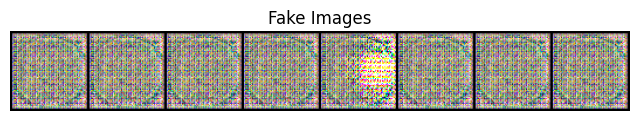

[101/2000][0/1]	Loss_D: 0.0103	Loss_G: 5.0433	D(x): 0.9991	D(G(z)): 0.0093 / 0.0069
[102/2000][0/1]	Loss_D: 0.0079	Loss_G: 5.2237	D(x): 0.9991	D(G(z)): 0.0070 / 0.0055
[103/2000][0/1]	Loss_D: 0.0105	Loss_G: 5.0655	D(x): 0.9992	D(G(z)): 0.0096 / 0.0071
[104/2000][0/1]	Loss_D: 0.0086	Loss_G: 5.1562	D(x): 0.9992	D(G(z)): 0.0077 / 0.0060
[105/2000][0/1]	Loss_D: 0.0114	Loss_G: 4.9341	D(x): 0.9992	D(G(z)): 0.0106 / 0.0078
[106/2000][0/1]	Loss_D: 0.0108	Loss_G: 4.9922	D(x): 0.9992	D(G(z)): 0.0100 / 0.0073
[107/2000][0/1]	Loss_D: 0.0088	Loss_G: 5.1565	D(x): 0.9992	D(G(z)): 0.0080 / 0.0060
[108/2000][0/1]	Loss_D: 0.0086	Loss_G: 5.2555	D(x): 0.9992	D(G(z)): 0.0078 / 0.0057
[109/2000][0/1]	Loss_D: 0.0055	Loss_G: 5.5810	D(x): 0.9993	D(G(z)): 0.0047 / 0.0038
[110/2000][0/1]	Loss_D: 0.0106	Loss_G: 4.9523	D(x): 0.9993	D(G(z)): 0.0099 / 0.0077
[111/2000][0/1]	Loss_D: 0.0100	Loss_G: 5.0763	D(x): 0.9993	D(G(z)): 0.0093 / 0.0068
[112/2000][0/1]	Loss_D: 0.0075	Loss_G: 5.3065	D(x): 0.9993	D(G(z)): 0.0068 /

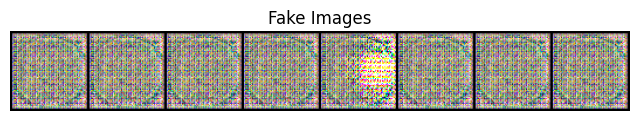

[151/2000][0/1]	Loss_D: 0.0044	Loss_G: 5.7207	D(x): 0.9997	D(G(z)): 0.0041 / 0.0036
[152/2000][0/1]	Loss_D: 0.0057	Loss_G: 5.5256	D(x): 0.9997	D(G(z)): 0.0053 / 0.0045
[153/2000][0/1]	Loss_D: 0.0061	Loss_G: 5.5286	D(x): 0.9997	D(G(z)): 0.0058 / 0.0047
[154/2000][0/1]	Loss_D: 0.0049	Loss_G: 5.7693	D(x): 0.9997	D(G(z)): 0.0045 / 0.0037
[155/2000][0/1]	Loss_D: 0.0022	Loss_G: 6.5634	D(x): 0.9997	D(G(z)): 0.0019 / 0.0016
[156/2000][0/1]	Loss_D: 0.0018	Loss_G: 6.6580	D(x): 0.9997	D(G(z)): 0.0014 / 0.0013
[157/2000][0/1]	Loss_D: 0.0025	Loss_G: 6.2042	D(x): 0.9997	D(G(z)): 0.0022 / 0.0021
[158/2000][0/1]	Loss_D: 0.0033	Loss_G: 5.9748	D(x): 0.9997	D(G(z)): 0.0030 / 0.0027
[159/2000][0/1]	Loss_D: 0.0044	Loss_G: 5.7540	D(x): 0.9997	D(G(z)): 0.0041 / 0.0037
[160/2000][0/1]	Loss_D: 0.0054	Loss_G: 5.6386	D(x): 0.9997	D(G(z)): 0.0051 / 0.0044
[161/2000][0/1]	Loss_D: 0.0057	Loss_G: 5.6129	D(x): 0.9997	D(G(z)): 0.0053 / 0.0045
[162/2000][0/1]	Loss_D: 0.0049	Loss_G: 5.8012	D(x): 0.9997	D(G(z)): 0.0046 /

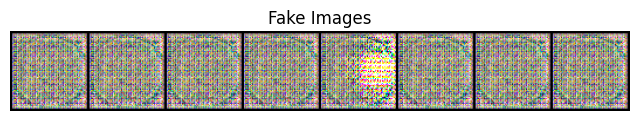

[201/2000][0/1]	Loss_D: 0.0023	Loss_G: 6.4092	D(x): 0.9998	D(G(z)): 0.0021 / 0.0018
[202/2000][0/1]	Loss_D: 0.0024	Loss_G: 6.4495	D(x): 0.9998	D(G(z)): 0.0021 / 0.0019
[203/2000][0/1]	Loss_D: 0.0015	Loss_G: 6.8755	D(x): 0.9998	D(G(z)): 0.0013 / 0.0011
[204/2000][0/1]	Loss_D: 0.0019	Loss_G: 6.5178	D(x): 0.9998	D(G(z)): 0.0017 / 0.0016
[205/2000][0/1]	Loss_D: 0.0025	Loss_G: 6.2973	D(x): 0.9998	D(G(z)): 0.0023 / 0.0021
[206/2000][0/1]	Loss_D: 0.0028	Loss_G: 6.2104	D(x): 0.9998	D(G(z)): 0.0026 / 0.0023
[207/2000][0/1]	Loss_D: 0.0031	Loss_G: 6.1993	D(x): 0.9998	D(G(z)): 0.0029 / 0.0024
[208/2000][0/1]	Loss_D: 0.0021	Loss_G: 6.5378	D(x): 0.9998	D(G(z)): 0.0019 / 0.0016
[209/2000][0/1]	Loss_D: 0.0014	Loss_G: 6.9364	D(x): 0.9998	D(G(z)): 0.0012 / 0.0011
[210/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.0278	D(x): 0.9998	D(G(z)): 0.0010 / 0.0009
[211/2000][0/1]	Loss_D: 0.0018	Loss_G: 6.5584	D(x): 0.9998	D(G(z)): 0.0016 / 0.0015
[212/2000][0/1]	Loss_D: 0.0022	Loss_G: 6.4386	D(x): 0.9998	D(G(z)): 0.0020 /

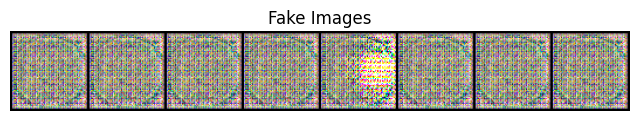

[251/2000][0/1]	Loss_D: 0.0016	Loss_G: 6.7700	D(x): 0.9998	D(G(z)): 0.0015 / 0.0012
[252/2000][0/1]	Loss_D: 0.0016	Loss_G: 6.8722	D(x): 0.9998	D(G(z)): 0.0015 / 0.0012
[253/2000][0/1]	Loss_D: 0.0006	Loss_G: 7.8335	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[254/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.1320	D(x): 0.9998	D(G(z)): 0.0010 / 0.0009
[255/2000][0/1]	Loss_D: 0.0011	Loss_G: 7.2325	D(x): 0.9998	D(G(z)): 0.0009 / 0.0008
[256/2000][0/1]	Loss_D: 0.0012	Loss_G: 6.9734	D(x): 0.9998	D(G(z)): 0.0011 / 0.0010
[257/2000][0/1]	Loss_D: 0.0017	Loss_G: 6.8058	D(x): 0.9998	D(G(z)): 0.0015 / 0.0013
[258/2000][0/1]	Loss_D: 0.0008	Loss_G: 7.6150	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006
[259/2000][0/1]	Loss_D: 0.0007	Loss_G: 7.7001	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[260/2000][0/1]	Loss_D: 0.0008	Loss_G: 7.5306	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006
[261/2000][0/1]	Loss_D: 0.0014	Loss_G: 6.8098	D(x): 0.9998	D(G(z)): 0.0012 / 0.0011
[262/2000][0/1]	Loss_D: 0.0018	Loss_G: 6.9431	D(x): 0.9998	D(G(z)): 0.0016 /

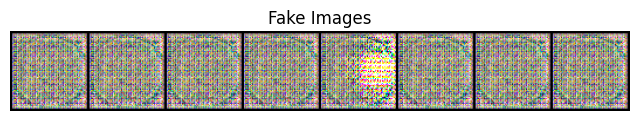

[301/2000][0/1]	Loss_D: 0.2293	Loss_G: 3.3254	D(x): 0.9905	D(G(z)): 0.1614 / 0.0766
[302/2000][0/1]	Loss_D: 0.2265	Loss_G: 3.8298	D(x): 0.9844	D(G(z)): 0.1401 / 0.0591
[303/2000][0/1]	Loss_D: 0.1407	Loss_G: 3.9361	D(x): 0.9735	D(G(z)): 0.0929 / 0.0386
[304/2000][0/1]	Loss_D: 0.1121	Loss_G: 3.6725	D(x): 0.9713	D(G(z)): 0.0757 / 0.0370
[305/2000][0/1]	Loss_D: 0.1241	Loss_G: 3.4797	D(x): 0.9786	D(G(z)): 0.0957 / 0.0383
[306/2000][0/1]	Loss_D: 0.1404	Loss_G: 3.7546	D(x): 0.9806	D(G(z)): 0.1129 / 0.0296
[307/2000][0/1]	Loss_D: 0.1166	Loss_G: 4.1367	D(x): 0.9725	D(G(z)): 0.0841 / 0.0201
[308/2000][0/1]	Loss_D: 0.1267	Loss_G: 4.4211	D(x): 0.9699	D(G(z)): 0.0911 / 0.0153
[309/2000][0/1]	Loss_D: 0.1426	Loss_G: 5.4980	D(x): 0.9652	D(G(z)): 0.0993 / 0.0064
[310/2000][0/1]	Loss_D: 0.1053	Loss_G: 4.5764	D(x): 0.9377	D(G(z)): 0.0376 / 0.0138
[311/2000][0/1]	Loss_D: 0.2557	Loss_G: 10.0854	D(x): 0.9856	D(G(z)): 0.2107 / 0.0001
[312/2000][0/1]	Loss_D: 2.7195	Loss_G: 0.0011	D(x): 0.1068	D(G(z)): 0.0010 

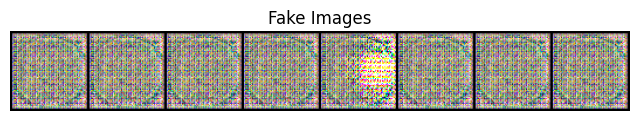

[351/2000][0/1]	Loss_D: 1.9616	Loss_G: 3.4332	D(x): 0.9987	D(G(z)): 0.7490 / 0.0493
[352/2000][0/1]	Loss_D: 0.1789	Loss_G: 4.2819	D(x): 0.9785	D(G(z)): 0.1391 / 0.0268
[353/2000][0/1]	Loss_D: 0.2421	Loss_G: 3.6532	D(x): 0.8602	D(G(z)): 0.0677 / 0.0475
[354/2000][0/1]	Loss_D: 0.1926	Loss_G: 3.1512	D(x): 0.9455	D(G(z)): 0.1244 / 0.0644
[355/2000][0/1]	Loss_D: 0.2853	Loss_G: 3.7603	D(x): 0.9667	D(G(z)): 0.2160 / 0.0313
[356/2000][0/1]	Loss_D: 0.3359	Loss_G: 4.6614	D(x): 0.9027	D(G(z)): 0.1989 / 0.0120
[357/2000][0/1]	Loss_D: 0.5638	Loss_G: 3.5636	D(x): 0.7428	D(G(z)): 0.1790 / 0.0298
[358/2000][0/1]	Loss_D: 0.6872	Loss_G: 7.3669	D(x): 0.9198	D(G(z)): 0.4373 / 0.0015
[359/2000][0/1]	Loss_D: 1.9998	Loss_G: 2.0672	D(x): 0.1684	D(G(z)): 0.0065 / 0.1565
[360/2000][0/1]	Loss_D: 0.5665	Loss_G: 2.6561	D(x): 0.9990	D(G(z)): 0.4188 / 0.1045
[361/2000][0/1]	Loss_D: 0.6473	Loss_G: 5.9981	D(x): 0.9937	D(G(z)): 0.4115 / 0.0042
[362/2000][0/1]	Loss_D: 0.2440	Loss_G: 5.5177	D(x): 0.8280	D(G(z)): 0.0181 /

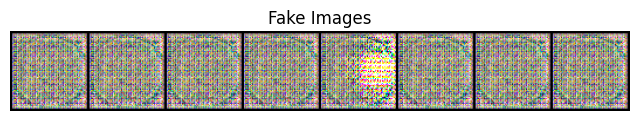

[401/2000][0/1]	Loss_D: 0.0576	Loss_G: 3.2926	D(x): 0.9766	D(G(z)): 0.0329 / 0.0444
[402/2000][0/1]	Loss_D: 0.0556	Loss_G: 3.9210	D(x): 0.9810	D(G(z)): 0.0353 / 0.0307
[403/2000][0/1]	Loss_D: 0.2208	Loss_G: 5.8775	D(x): 0.9857	D(G(z)): 0.1824 / 0.0029
[404/2000][0/1]	Loss_D: 0.0695	Loss_G: 4.8240	D(x): 0.9763	D(G(z)): 0.0440 / 0.0094
[405/2000][0/1]	Loss_D: 0.6691	Loss_G: 10.1945	D(x): 0.9738	D(G(z)): 0.4599 / 0.0001
[406/2000][0/1]	Loss_D: 2.6593	Loss_G: 4.2039	D(x): 0.1204	D(G(z)): 0.0010 / 0.0256
[407/2000][0/1]	Loss_D: 1.7093	Loss_G: 9.4903	D(x): 0.9662	D(G(z)): 0.7739 / 0.0001
[408/2000][0/1]	Loss_D: 5.7234	Loss_G: 3.4394	D(x): 0.0133	D(G(z)): 0.0037 / 0.0517
[409/2000][0/1]	Loss_D: 1.7529	Loss_G: 5.4882	D(x): 0.9847	D(G(z)): 0.8172 / 0.0095
[410/2000][0/1]	Loss_D: 0.4390	Loss_G: 4.3195	D(x): 0.7599	D(G(z)): 0.1159 / 0.0174
[411/2000][0/1]	Loss_D: 0.4471	Loss_G: 2.1470	D(x): 0.7466	D(G(z)): 0.1258 / 0.1202
[412/2000][0/1]	Loss_D: 0.6243	Loss_G: 4.8891	D(x): 0.9333	D(G(z)): 0.4170 

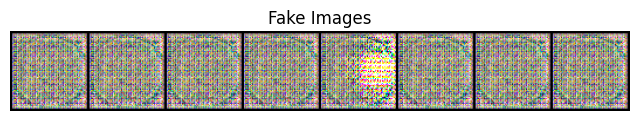

[451/2000][0/1]	Loss_D: 0.0401	Loss_G: 4.6362	D(x): 0.9831	D(G(z)): 0.0227 / 0.0152
[452/2000][0/1]	Loss_D: 0.0768	Loss_G: 4.7212	D(x): 0.9889	D(G(z)): 0.0629 / 0.0111
[453/2000][0/1]	Loss_D: 0.0771	Loss_G: 4.8135	D(x): 0.9814	D(G(z)): 0.0563 / 0.0110
[454/2000][0/1]	Loss_D: 0.0484	Loss_G: 5.8896	D(x): 0.9561	D(G(z)): 0.0034 / 0.0030
[455/2000][0/1]	Loss_D: 0.0181	Loss_G: 7.3636	D(x): 0.9829	D(G(z)): 0.0009 / 0.0011
[456/2000][0/1]	Loss_D: 0.0805	Loss_G: 5.0017	D(x): 0.9911	D(G(z)): 0.0685 / 0.0098
[457/2000][0/1]	Loss_D: 0.0156	Loss_G: 6.0667	D(x): 0.9875	D(G(z)): 0.0030 / 0.0024
[458/2000][0/1]	Loss_D: 0.0239	Loss_G: 5.3309	D(x): 0.9857	D(G(z)): 0.0094 / 0.0073
[459/2000][0/1]	Loss_D: 0.0291	Loss_G: 4.7175	D(x): 0.9903	D(G(z)): 0.0192 / 0.0105
[460/2000][0/1]	Loss_D: 0.0152	Loss_G: 5.5911	D(x): 0.9914	D(G(z)): 0.0065 / 0.0056
[461/2000][0/1]	Loss_D: 0.1865	Loss_G: 8.1923	D(x): 0.9928	D(G(z)): 0.1630 / 0.0003
[462/2000][0/1]	Loss_D: 0.9694	Loss_G: 0.1214	D(x): 0.3913	D(G(z)): 0.0008 /

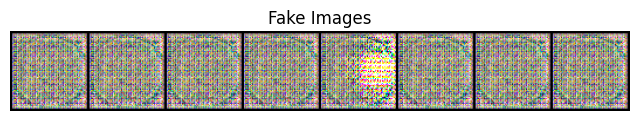

[501/2000][0/1]	Loss_D: 0.0349	Loss_G: 7.1912	D(x): 0.9791	D(G(z)): 0.0134 / 0.0012
[502/2000][0/1]	Loss_D: 0.1354	Loss_G: 4.5182	D(x): 0.8888	D(G(z)): 0.0143 / 0.0117
[503/2000][0/1]	Loss_D: 0.1588	Loss_G: 4.4385	D(x): 0.9823	D(G(z)): 0.1275 / 0.0130
[504/2000][0/1]	Loss_D: 0.1676	Loss_G: 5.3402	D(x): 0.9834	D(G(z)): 0.1384 / 0.0080
[505/2000][0/1]	Loss_D: 0.1350	Loss_G: 5.0760	D(x): 0.9511	D(G(z)): 0.0770 / 0.0082
[506/2000][0/1]	Loss_D: 0.1123	Loss_G: 4.7123	D(x): 0.9547	D(G(z)): 0.0630 / 0.0103
[507/2000][0/1]	Loss_D: 0.0487	Loss_G: 4.5281	D(x): 0.9726	D(G(z)): 0.0206 / 0.0121
[508/2000][0/1]	Loss_D: 0.1263	Loss_G: 4.8659	D(x): 0.9851	D(G(z)): 0.1027 / 0.0108
[509/2000][0/1]	Loss_D: 0.0489	Loss_G: 4.6499	D(x): 0.9753	D(G(z)): 0.0235 / 0.0107
[510/2000][0/1]	Loss_D: 0.1218	Loss_G: 4.5797	D(x): 0.9776	D(G(z)): 0.0940 / 0.0123
[511/2000][0/1]	Loss_D: 0.0965	Loss_G: 4.4914	D(x): 0.9573	D(G(z)): 0.0510 / 0.0134
[512/2000][0/1]	Loss_D: 0.0583	Loss_G: 4.4205	D(x): 0.9673	D(G(z)): 0.0245 /

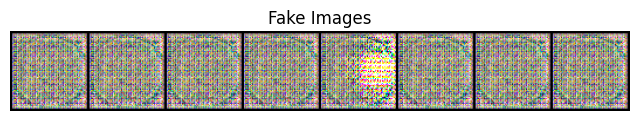

[551/2000][0/1]	Loss_D: 0.1186	Loss_G: 5.0854	D(x): 0.9720	D(G(z)): 0.0855 / 0.0132
[552/2000][0/1]	Loss_D: 0.0728	Loss_G: 5.0429	D(x): 0.9869	D(G(z)): 0.0577 / 0.0105
[553/2000][0/1]	Loss_D: 0.0471	Loss_G: 4.8554	D(x): 0.9914	D(G(z)): 0.0376 / 0.0088
[554/2000][0/1]	Loss_D: 0.0138	Loss_G: 6.0950	D(x): 0.9924	D(G(z)): 0.0062 / 0.0036
[555/2000][0/1]	Loss_D: 0.0079	Loss_G: 6.9766	D(x): 0.9938	D(G(z)): 0.0017 / 0.0014
[556/2000][0/1]	Loss_D: 0.0269	Loss_G: 4.7674	D(x): 0.9951	D(G(z)): 0.0217 / 0.0151
[557/2000][0/1]	Loss_D: 0.0241	Loss_G: 4.5664	D(x): 0.9955	D(G(z)): 0.0194 / 0.0110
[558/2000][0/1]	Loss_D: 0.0363	Loss_G: 4.2651	D(x): 0.9955	D(G(z)): 0.0312 / 0.0147
[559/2000][0/1]	Loss_D: 0.3403	Loss_G: 6.7341	D(x): 0.9947	D(G(z)): 0.2788 / 0.0013
[560/2000][0/1]	Loss_D: 0.2452	Loss_G: 4.7654	D(x): 0.8466	D(G(z)): 0.0144 / 0.0112
[561/2000][0/1]	Loss_D: 0.1912	Loss_G: 3.8457	D(x): 0.8800	D(G(z)): 0.0469 / 0.0243
[562/2000][0/1]	Loss_D: 0.0112	Loss_G: 5.1241	D(x): 0.9973	D(G(z)): 0.0085 /

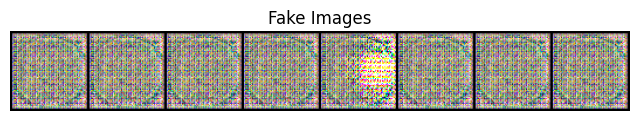

[601/2000][0/1]	Loss_D: 2.6351	Loss_G: 1.4366	D(x): 0.1756	D(G(z)): 0.0353 / 0.2800
[602/2000][0/1]	Loss_D: 1.0606	Loss_G: 5.0767	D(x): 0.9855	D(G(z)): 0.6426 / 0.0072
[603/2000][0/1]	Loss_D: 0.4701	Loss_G: 3.7272	D(x): 0.6669	D(G(z)): 0.0334 / 0.0312
[604/2000][0/1]	Loss_D: 0.1997	Loss_G: 3.3083	D(x): 0.9481	D(G(z)): 0.1346 / 0.0458
[605/2000][0/1]	Loss_D: 0.3151	Loss_G: 5.0162	D(x): 0.9679	D(G(z)): 0.2414 / 0.0084
[606/2000][0/1]	Loss_D: 0.2382	Loss_G: 3.8712	D(x): 0.8339	D(G(z)): 0.0479 / 0.0246
[607/2000][0/1]	Loss_D: 0.2350	Loss_G: 4.4259	D(x): 0.9611	D(G(z)): 0.1742 / 0.0135
[608/2000][0/1]	Loss_D: 0.2012	Loss_G: 4.6702	D(x): 0.9265	D(G(z)): 0.1157 / 0.0103
[609/2000][0/1]	Loss_D: 0.1958	Loss_G: 3.7765	D(x): 0.8774	D(G(z)): 0.0608 / 0.0266
[610/2000][0/1]	Loss_D: 0.2017	Loss_G: 5.2220	D(x): 0.9533	D(G(z)): 0.1388 / 0.0054
[611/2000][0/1]	Loss_D: 0.1029	Loss_G: 4.8483	D(x): 0.9133	D(G(z)): 0.0092 / 0.0079
[612/2000][0/1]	Loss_D: 0.1556	Loss_G: 5.2526	D(x): 0.9768	D(G(z)): 0.1227 /

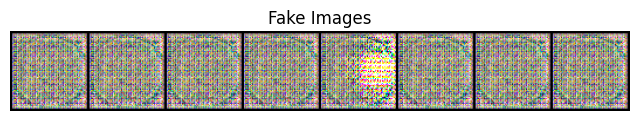

[651/2000][0/1]	Loss_D: 0.0444	Loss_G: 4.7488	D(x): 0.9767	D(G(z)): 0.0205 / 0.0098
[652/2000][0/1]	Loss_D: 0.1549	Loss_G: 5.5970	D(x): 0.9835	D(G(z)): 0.1281 / 0.0045
[653/2000][0/1]	Loss_D: 0.1095	Loss_G: 5.3055	D(x): 0.9119	D(G(z)): 0.0165 / 0.0052
[654/2000][0/1]	Loss_D: 0.0229	Loss_G: 4.6803	D(x): 0.9889	D(G(z)): 0.0117 / 0.0106
[655/2000][0/1]	Loss_D: 0.0500	Loss_G: 4.6472	D(x): 0.9946	D(G(z)): 0.0436 / 0.0097
[656/2000][0/1]	Loss_D: 0.3336	Loss_G: 12.1458	D(x): 0.9940	D(G(z)): 0.2745 / 0.0000
[657/2000][0/1]	Loss_D: 0.6989	Loss_G: 3.4614	D(x): 0.5108	D(G(z)): 0.0003 / 0.0361
[658/2000][0/1]	Loss_D: 0.0613	Loss_G: 3.0891	D(x): 0.9988	D(G(z)): 0.0581 / 0.0462
[659/2000][0/1]	Loss_D: 1.3889	Loss_G: 16.9406	D(x): 0.9986	D(G(z)): 0.6906 / 0.0000
[660/2000][0/1]	Loss_D: 5.0941	Loss_G: 13.4073	D(x): 0.0071	D(G(z)): 0.0000 / 0.0000
[661/2000][0/1]	Loss_D: 0.0007	Loss_G: 9.3510	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[662/2000][0/1]	Loss_D: 0.0016	Loss_G: 6.7037	D(x): 0.9995	D(G(z)): 0.001

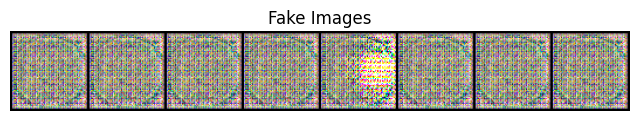

[701/2000][0/1]	Loss_D: 0.1637	Loss_G: 0.6767	D(x): 0.9382	D(G(z)): 0.0924 / 0.5334
[702/2000][0/1]	Loss_D: 2.4806	Loss_G: 17.3484	D(x): 0.9987	D(G(z)): 0.8957 / 0.0000
[703/2000][0/1]	Loss_D: 8.7488	Loss_G: 11.1333	D(x): 0.0006	D(G(z)): 0.0000 / 0.0002
[704/2000][0/1]	Loss_D: 0.0113	Loss_G: 7.1278	D(x): 0.9906	D(G(z)): 0.0017 / 0.0094
[705/2000][0/1]	Loss_D: 0.1800	Loss_G: 4.8980	D(x): 0.9964	D(G(z)): 0.1596 / 0.0527
[706/2000][0/1]	Loss_D: 1.2476	Loss_G: 10.2146	D(x): 0.9963	D(G(z)): 0.6605 / 0.0001
[707/2000][0/1]	Loss_D: 0.0408	Loss_G: 11.8532	D(x): 0.9610	D(G(z)): 0.0003 / 0.0000
[708/2000][0/1]	Loss_D: 0.0421	Loss_G: 11.7093	D(x): 0.9593	D(G(z)): 0.0000 / 0.0000
[709/2000][0/1]	Loss_D: 0.0148	Loss_G: 10.6145	D(x): 0.9854	D(G(z)): 0.0001 / 0.0001
[710/2000][0/1]	Loss_D: 0.0068	Loss_G: 8.8737	D(x): 0.9937	D(G(z)): 0.0004 / 0.0004
[711/2000][0/1]	Loss_D: 0.0068	Loss_G: 6.6154	D(x): 0.9965	D(G(z)): 0.0033 / 0.0027
[712/2000][0/1]	Loss_D: 0.0462	Loss_G: 4.2053	D(x): 0.9976	D(G(z)): 0.

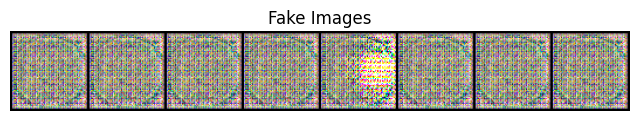

[751/2000][0/1]	Loss_D: 0.0856	Loss_G: 4.4380	D(x): 0.9957	D(G(z)): 0.0758 / 0.0159
[752/2000][0/1]	Loss_D: 0.1814	Loss_G: 5.6004	D(x): 0.9956	D(G(z)): 0.1561 / 0.0057
[753/2000][0/1]	Loss_D: 0.0380	Loss_G: 5.8628	D(x): 0.9837	D(G(z)): 0.0212 / 0.0050
[754/2000][0/1]	Loss_D: 0.0717	Loss_G: 5.1371	D(x): 0.9615	D(G(z)): 0.0310 / 0.0089
[755/2000][0/1]	Loss_D: 0.0912	Loss_G: 4.7397	D(x): 0.9668	D(G(z)): 0.0532 / 0.0104
[756/2000][0/1]	Loss_D: 0.0743	Loss_G: 4.9056	D(x): 0.9736	D(G(z)): 0.0454 / 0.0080
[757/2000][0/1]	Loss_D: 0.0350	Loss_G: 5.2571	D(x): 0.9741	D(G(z)): 0.0086 / 0.0052
[758/2000][0/1]	Loss_D: 0.1880	Loss_G: 6.3532	D(x): 0.9837	D(G(z)): 0.1543 / 0.0018
[759/2000][0/1]	Loss_D: 0.1312	Loss_G: 5.2441	D(x): 0.8852	D(G(z)): 0.0065 / 0.0054
[760/2000][0/1]	Loss_D: 0.0240	Loss_G: 5.4860	D(x): 0.9831	D(G(z)): 0.0069 / 0.0055
[761/2000][0/1]	Loss_D: 0.0580	Loss_G: 4.5576	D(x): 0.9942	D(G(z)): 0.0508 / 0.0106
[762/2000][0/1]	Loss_D: 0.0363	Loss_G: 5.1941	D(x): 0.9941	D(G(z)): 0.0298 /

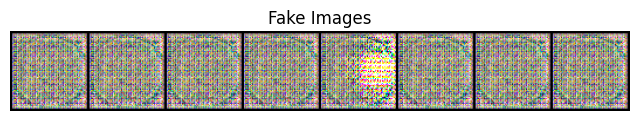

[801/2000][0/1]	Loss_D: 0.1100	Loss_G: 5.4509	D(x): 0.9388	D(G(z)): 0.0431 / 0.0084
[802/2000][0/1]	Loss_D: 0.1518	Loss_G: 5.4514	D(x): 0.9623	D(G(z)): 0.1057 / 0.0072
[803/2000][0/1]	Loss_D: 0.1318	Loss_G: 4.7744	D(x): 0.9292	D(G(z)): 0.0555 / 0.0123
[804/2000][0/1]	Loss_D: 0.1535	Loss_G: 5.9932	D(x): 0.9690	D(G(z)): 0.1138 / 0.0035
[805/2000][0/1]	Loss_D: 0.1157	Loss_G: 4.8681	D(x): 0.9160	D(G(z)): 0.0271 / 0.0109
[806/2000][0/1]	Loss_D: 0.0984	Loss_G: 5.6325	D(x): 0.9851	D(G(z)): 0.0789 / 0.0049
[807/2000][0/1]	Loss_D: 0.0539	Loss_G: 5.7423	D(x): 0.9772	D(G(z)): 0.0302 / 0.0043
[808/2000][0/1]	Loss_D: 0.0460	Loss_G: 5.2540	D(x): 0.9728	D(G(z)): 0.0181 / 0.0071
[809/2000][0/1]	Loss_D: 0.0523	Loss_G: 5.1148	D(x): 0.9826	D(G(z)): 0.0339 / 0.0089
[810/2000][0/1]	Loss_D: 0.0621	Loss_G: 5.1991	D(x): 0.9831	D(G(z)): 0.0439 / 0.0080
[811/2000][0/1]	Loss_D: 0.1034	Loss_G: 6.0914	D(x): 0.9770	D(G(z)): 0.0763 / 0.0035
[812/2000][0/1]	Loss_D: 0.0939	Loss_G: 4.6499	D(x): 0.9265	D(G(z)): 0.0169 /

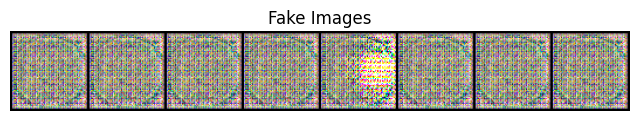

[851/2000][0/1]	Loss_D: 0.0031	Loss_G: 9.9011	D(x): 0.9970	D(G(z)): 0.0001 / 0.0001
[852/2000][0/1]	Loss_D: 0.0034	Loss_G: 8.3774	D(x): 0.9971	D(G(z)): 0.0005 / 0.0004
[853/2000][0/1]	Loss_D: 0.0029	Loss_G: 8.2675	D(x): 0.9974	D(G(z)): 0.0003 / 0.0003
[854/2000][0/1]	Loss_D: 0.0076	Loss_G: 6.0377	D(x): 0.9977	D(G(z)): 0.0053 / 0.0038
[855/2000][0/1]	Loss_D: 0.0047	Loss_G: 6.3987	D(x): 0.9980	D(G(z)): 0.0027 / 0.0021
[856/2000][0/1]	Loss_D: 0.0118	Loss_G: 5.5048	D(x): 0.9982	D(G(z)): 0.0099 / 0.0054
[857/2000][0/1]	Loss_D: 0.0656	Loss_G: 7.3786	D(x): 0.9983	D(G(z)): 0.0614 / 0.0007
[858/2000][0/1]	Loss_D: 0.0031	Loss_G: 7.9946	D(x): 0.9981	D(G(z)): 0.0012 / 0.0003
[859/2000][0/1]	Loss_D: 0.0067	Loss_G: 6.1884	D(x): 0.9981	D(G(z)): 0.0048 / 0.0021
[860/2000][0/1]	Loss_D: 0.0221	Loss_G: 5.4599	D(x): 0.9981	D(G(z)): 0.0200 / 0.0046
[861/2000][0/1]	Loss_D: 0.0101	Loss_G: 6.0257	D(x): 0.9982	D(G(z)): 0.0082 / 0.0027
[862/2000][0/1]	Loss_D: 0.0025	Loss_G: 7.8336	D(x): 0.9982	D(G(z)): 0.0007 /

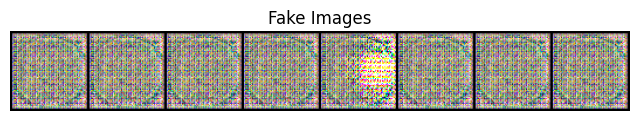

[901/2000][0/1]	Loss_D: 0.0125	Loss_G: 4.9680	D(x): 0.9991	D(G(z)): 0.0115 / 0.0093
[902/2000][0/1]	Loss_D: 0.0114	Loss_G: 5.0427	D(x): 0.9991	D(G(z)): 0.0105 / 0.0082
[903/2000][0/1]	Loss_D: 0.0051	Loss_G: 5.7927	D(x): 0.9991	D(G(z)): 0.0042 / 0.0036
[904/2000][0/1]	Loss_D: 0.0061	Loss_G: 5.5395	D(x): 0.9991	D(G(z)): 0.0052 / 0.0044
[905/2000][0/1]	Loss_D: 0.0090	Loss_G: 5.1307	D(x): 0.9992	D(G(z)): 0.0082 / 0.0070
[906/2000][0/1]	Loss_D: 0.0119	Loss_G: 4.8889	D(x): 0.9992	D(G(z)): 0.0110 / 0.0091
[907/2000][0/1]	Loss_D: 0.0090	Loss_G: 5.1712	D(x): 0.9992	D(G(z)): 0.0081 / 0.0065
[908/2000][0/1]	Loss_D: 0.0076	Loss_G: 5.3782	D(x): 0.9992	D(G(z)): 0.0068 / 0.0056
[909/2000][0/1]	Loss_D: 0.0081	Loss_G: 5.2711	D(x): 0.9992	D(G(z)): 0.0072 / 0.0059
[910/2000][0/1]	Loss_D: 0.0084	Loss_G: 5.2853	D(x): 0.9992	D(G(z)): 0.0076 / 0.0061
[911/2000][0/1]	Loss_D: 0.0066	Loss_G: 5.4387	D(x): 0.9992	D(G(z)): 0.0058 / 0.0048
[912/2000][0/1]	Loss_D: 0.0022	Loss_G: 6.6872	D(x): 0.9992	D(G(z)): 0.0014 /

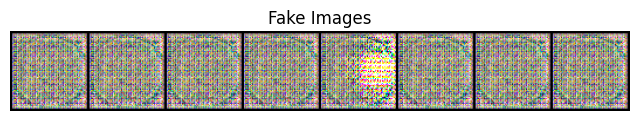

[951/2000][0/1]	Loss_D: 0.0075	Loss_G: 5.4420	D(x): 0.9989	D(G(z)): 0.0063 / 0.0044
[952/2000][0/1]	Loss_D: 0.0836	Loss_G: 7.8896	D(x): 0.9989	D(G(z)): 0.0781 / 0.0004
[953/2000][0/1]	Loss_D: 0.0026	Loss_G: 10.9470	D(x): 0.9975	D(G(z)): 0.0001 / 0.0000
[954/2000][0/1]	Loss_D: 0.0037	Loss_G: 11.1037	D(x): 0.9964	D(G(z)): 0.0000 / 0.0000
[955/2000][0/1]	Loss_D: 0.0041	Loss_G: 9.0739	D(x): 0.9962	D(G(z)): 0.0003 / 0.0002
[956/2000][0/1]	Loss_D: 0.0034	Loss_G: 10.3763	D(x): 0.9967	D(G(z)): 0.0001 / 0.0000
[957/2000][0/1]	Loss_D: 0.0029	Loss_G: 9.7093	D(x): 0.9972	D(G(z)): 0.0001 / 0.0001
[958/2000][0/1]	Loss_D: 0.0024	Loss_G: 10.3027	D(x): 0.9977	D(G(z)): 0.0001 / 0.0001
[959/2000][0/1]	Loss_D: 0.0022	Loss_G: 8.6198	D(x): 0.9981	D(G(z)): 0.0003 / 0.0003
[960/2000][0/1]	Loss_D: 0.0018	Loss_G: 9.5511	D(x): 0.9983	D(G(z)): 0.0001 / 0.0001
[961/2000][0/1]	Loss_D: 0.0034	Loss_G: 7.0210	D(x): 0.9985	D(G(z)): 0.0019 / 0.0018
[962/2000][0/1]	Loss_D: 0.0015	Loss_G: 8.9404	D(x): 0.9986	D(G(z)): 0.00

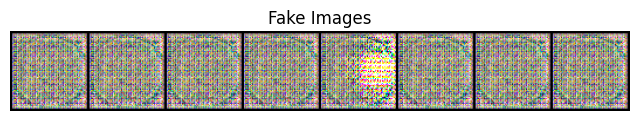

[1001/2000][0/1]	Loss_D: 0.0019	Loss_G: 8.1472	D(x): 0.9984	D(G(z)): 0.0003 / 0.0003
[1002/2000][0/1]	Loss_D: 0.0037	Loss_G: 6.3849	D(x): 0.9985	D(G(z)): 0.0022 / 0.0017
[1003/2000][0/1]	Loss_D: 0.0046	Loss_G: 6.1375	D(x): 0.9986	D(G(z)): 0.0033 / 0.0022
[1004/2000][0/1]	Loss_D: 0.0031	Loss_G: 6.6757	D(x): 0.9987	D(G(z)): 0.0017 / 0.0013
[1005/2000][0/1]	Loss_D: 0.0027	Loss_G: 6.8127	D(x): 0.9987	D(G(z)): 0.0014 / 0.0011
[1006/2000][0/1]	Loss_D: 0.0041	Loss_G: 6.3318	D(x): 0.9988	D(G(z)): 0.0028 / 0.0020
[1007/2000][0/1]	Loss_D: 0.0040	Loss_G: 6.3839	D(x): 0.9988	D(G(z)): 0.0028 / 0.0018
[1008/2000][0/1]	Loss_D: 0.0020	Loss_G: 7.5613	D(x): 0.9988	D(G(z)): 0.0008 / 0.0007
[1009/2000][0/1]	Loss_D: 0.0250	Loss_G: 6.6192	D(x): 0.9988	D(G(z)): 0.0235 / 0.0016
[1010/2000][0/1]	Loss_D: 0.0020	Loss_G: 9.0144	D(x): 0.9982	D(G(z)): 0.0002 / 0.0001
[1011/2000][0/1]	Loss_D: 0.0026	Loss_G: 8.0980	D(x): 0.9980	D(G(z)): 0.0006 / 0.0004
[1012/2000][0/1]	Loss_D: 0.0028	Loss_G: 7.6419	D(x): 0.9980	D(G(z

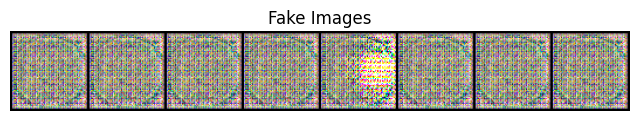

[1051/2000][0/1]	Loss_D: 0.0038	Loss_G: 6.3282	D(x): 0.9988	D(G(z)): 0.0026 / 0.0018
[1052/2000][0/1]	Loss_D: 0.0015	Loss_G: 8.1761	D(x): 0.9988	D(G(z)): 0.0003 / 0.0003
[1053/2000][0/1]	Loss_D: 0.0015	Loss_G: 8.1678	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003
[1054/2000][0/1]	Loss_D: 0.0030	Loss_G: 6.5126	D(x): 0.9989	D(G(z)): 0.0019 / 0.0015
[1055/2000][0/1]	Loss_D: 0.0013	Loss_G: 8.5047	D(x): 0.9990	D(G(z)): 0.0003 / 0.0003
[1056/2000][0/1]	Loss_D: 0.0070	Loss_G: 5.7956	D(x): 0.9990	D(G(z)): 0.0060 / 0.0033
[1057/2000][0/1]	Loss_D: 0.0014	Loss_G: 8.0983	D(x): 0.9990	D(G(z)): 0.0004 / 0.0003
[1058/2000][0/1]	Loss_D: 0.0015	Loss_G: 7.8780	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004
[1059/2000][0/1]	Loss_D: 0.0014	Loss_G: 8.3409	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004
[1060/2000][0/1]	Loss_D: 0.0131	Loss_G: 5.6478	D(x): 0.9991	D(G(z)): 0.0120 / 0.0046
[1061/2000][0/1]	Loss_D: 0.0057	Loss_G: 6.3703	D(x): 0.9989	D(G(z)): 0.0046 / 0.0018
[1062/2000][0/1]	Loss_D: 0.0015	Loss_G: 9.4445	D(x): 0.9986	D(G(z

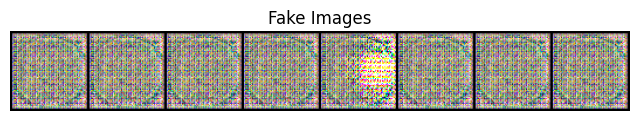

[1101/2000][0/1]	Loss_D: 0.0022	Loss_G: 6.7473	D(x): 0.9992	D(G(z)): 0.0013 / 0.0012
[1102/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.9883	D(x): 0.9992	D(G(z)): 0.0004 / 0.0003
[1103/2000][0/1]	Loss_D: 0.0047	Loss_G: 5.9314	D(x): 0.9992	D(G(z)): 0.0040 / 0.0028
[1104/2000][0/1]	Loss_D: 0.0031	Loss_G: 6.4528	D(x): 0.9992	D(G(z)): 0.0023 / 0.0016
[1105/2000][0/1]	Loss_D: 0.0009	Loss_G: 9.4933	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[1106/2000][0/1]	Loss_D: 0.0036	Loss_G: 6.1865	D(x): 0.9992	D(G(z)): 0.0028 / 0.0021
[1107/2000][0/1]	Loss_D: 0.0010	Loss_G: 9.0633	D(x): 0.9991	D(G(z)): 0.0002 / 0.0002
[1108/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.8701	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004
[1109/2000][0/1]	Loss_D: 0.0009	Loss_G: 10.1210	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[1110/2000][0/1]	Loss_D: 0.0024	Loss_G: 6.8802	D(x): 0.9993	D(G(z)): 0.0016 / 0.0015
[1111/2000][0/1]	Loss_D: 0.0065	Loss_G: 5.8653	D(x): 0.9993	D(G(z)): 0.0058 / 0.0029
[1112/2000][0/1]	Loss_D: 0.0009	Loss_G: 10.7646	D(x): 0.9992	D(G

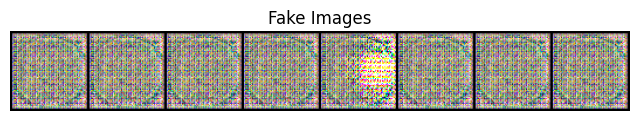

[1151/2000][0/1]	Loss_D: 0.0008	Loss_G: 9.5283	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[1152/2000][0/1]	Loss_D: 0.0010	Loss_G: 8.4719	D(x): 0.9993	D(G(z)): 0.0003 / 0.0002
[1153/2000][0/1]	Loss_D: 0.0008	Loss_G: 9.3695	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001
[1154/2000][0/1]	Loss_D: 0.0031	Loss_G: 6.4015	D(x): 0.9994	D(G(z)): 0.0024 / 0.0018
[1155/2000][0/1]	Loss_D: 0.0007	Loss_G: 10.1503	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[1156/2000][0/1]	Loss_D: 0.0008	Loss_G: 8.5098	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[1157/2000][0/1]	Loss_D: 0.0017	Loss_G: 6.9944	D(x): 0.9994	D(G(z)): 0.0011 / 0.0009
[1158/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.3306	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003
[1159/2000][0/1]	Loss_D: 0.0026	Loss_G: 6.5689	D(x): 0.9994	D(G(z)): 0.0020 / 0.0014
[1160/2000][0/1]	Loss_D: 0.0007	Loss_G: 9.0453	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001
[1161/2000][0/1]	Loss_D: 0.0020	Loss_G: 6.8499	D(x): 0.9994	D(G(z)): 0.0014 / 0.0011
[1162/2000][0/1]	Loss_D: 0.0015	Loss_G: 7.4112	D(x): 0.9994	D(G(

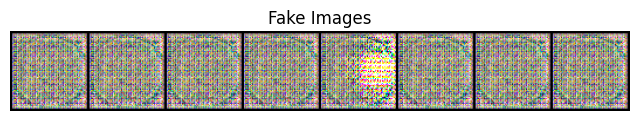

[1201/2000][0/1]	Loss_D: 0.0027	Loss_G: 6.9782	D(x): 0.9995	D(G(z)): 0.0022 / 0.0013
[1202/2000][0/1]	Loss_D: 0.0006	Loss_G: 10.3862	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000
[1203/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.6379	D(x): 0.9995	D(G(z)): 0.0007 / 0.0006
[1204/2000][0/1]	Loss_D: 0.0008	Loss_G: 8.2167	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003
[1205/2000][0/1]	Loss_D: 0.0006	Loss_G: 8.8076	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[1206/2000][0/1]	Loss_D: 0.0034	Loss_G: 6.3617	D(x): 0.9995	D(G(z)): 0.0029 / 0.0018
[1207/2000][0/1]	Loss_D: 0.0007	Loss_G: 8.8989	D(x): 0.9995	D(G(z)): 0.0002 / 0.0001
[1208/2000][0/1]	Loss_D: 0.0039	Loss_G: 6.4479	D(x): 0.9995	D(G(z)): 0.0034 / 0.0016
[1209/2000][0/1]	Loss_D: 0.0008	Loss_G: 8.8155	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[1210/2000][0/1]	Loss_D: 0.0036	Loss_G: 6.5534	D(x): 0.9994	D(G(z)): 0.0029 / 0.0015
[1211/2000][0/1]	Loss_D: 0.0008	Loss_G: 11.2213	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[1212/2000][0/1]	Loss_D: 0.0020	Loss_G: 7.0603	D(x): 0.9993	D(G

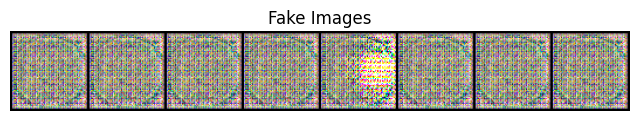

[1251/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.7654	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005
[1252/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.6826	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005
[1253/2000][0/1]	Loss_D: 0.0007	Loss_G: 8.4617	D(x): 0.9996	D(G(z)): 0.0003 / 0.0002
[1254/2000][0/1]	Loss_D: 0.0014	Loss_G: 7.3620	D(x): 0.9996	D(G(z)): 0.0010 / 0.0008
[1255/2000][0/1]	Loss_D: 0.0016	Loss_G: 7.1011	D(x): 0.9996	D(G(z)): 0.0012 / 0.0009
[1256/2000][0/1]	Loss_D: 0.0005	Loss_G: 10.6555	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[1257/2000][0/1]	Loss_D: 0.0033	Loss_G: 6.3028	D(x): 0.9996	D(G(z)): 0.0029 / 0.0019
[1258/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.0222	D(x): 0.9995	D(G(z)): 0.0004 / 0.0003
[1259/2000][0/1]	Loss_D: 0.0005	Loss_G: 9.7061	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[1260/2000][0/1]	Loss_D: 0.0014	Loss_G: 7.2310	D(x): 0.9995	D(G(z)): 0.0009 / 0.0008
[1261/2000][0/1]	Loss_D: 0.0006	Loss_G: 8.9879	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001
[1262/2000][0/1]	Loss_D: 0.0025	Loss_G: 6.5725	D(x): 0.9996	D(G(

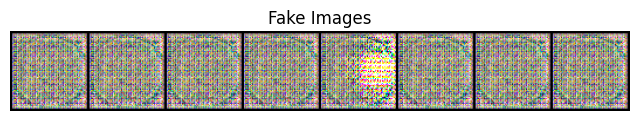

[1301/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.9561	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004
[1302/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.1183	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004
[1303/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.7750	D(x): 0.9995	D(G(z)): 0.0005 / 0.0004
[1304/2000][0/1]	Loss_D: 0.0011	Loss_G: 7.6020	D(x): 0.9995	D(G(z)): 0.0006 / 0.0006
[1305/2000][0/1]	Loss_D: 0.0006	Loss_G: 9.0312	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002
[1306/2000][0/1]	Loss_D: 0.0027	Loss_G: 6.5476	D(x): 0.9996	D(G(z)): 0.0022 / 0.0016
[1307/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.0357	D(x): 0.9995	D(G(z)): 0.0004 / 0.0003
[1308/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.7696	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005
[1309/2000][0/1]	Loss_D: 0.0014	Loss_G: 7.2051	D(x): 0.9995	D(G(z)): 0.0010 / 0.0008
[1310/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.7222	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005
[1311/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.3509	D(x): 0.9995	D(G(z)): 0.0008 / 0.0006
[1312/2000][0/1]	Loss_D: 0.0010	Loss_G: 7.9196	D(x): 0.9995	D(G(z

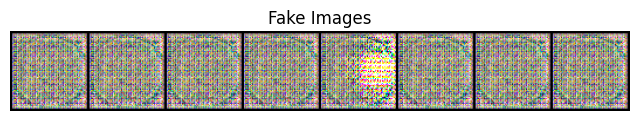

[1351/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.3933	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003
[1352/2000][0/1]	Loss_D: 0.0025	Loss_G: 6.6545	D(x): 0.9994	D(G(z)): 0.0019 / 0.0013
[1353/2000][0/1]	Loss_D: 0.0016	Loss_G: 7.2719	D(x): 0.9994	D(G(z)): 0.0010 / 0.0008
[1354/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.5575	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002
[1355/2000][0/1]	Loss_D: 0.0011	Loss_G: 7.8552	D(x): 0.9994	D(G(z)): 0.0005 / 0.0005
[1356/2000][0/1]	Loss_D: 0.0012	Loss_G: 7.5749	D(x): 0.9994	D(G(z)): 0.0007 / 0.0006
[1357/2000][0/1]	Loss_D: 0.0008	Loss_G: 8.5059	D(x): 0.9995	D(G(z)): 0.0003 / 0.0002
[1358/2000][0/1]	Loss_D: 0.0046	Loss_G: 6.3899	D(x): 0.9995	D(G(z)): 0.0041 / 0.0017
[1359/2000][0/1]	Loss_D: 0.0011	Loss_G: 8.1801	D(x): 0.9993	D(G(z)): 0.0005 / 0.0003
[1360/2000][0/1]	Loss_D: 0.0008	Loss_G: 9.8791	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001
[1361/2000][0/1]	Loss_D: 0.0013	Loss_G: 7.6853	D(x): 0.9993	D(G(z)): 0.0006 / 0.0005
[1362/2000][0/1]	Loss_D: 0.0015	Loss_G: 7.2046	D(x): 0.9993	D(G(z

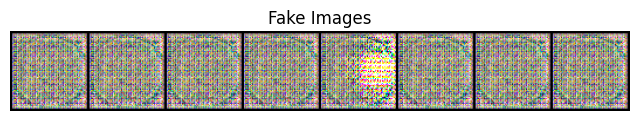

[1401/2000][0/1]	Loss_D: 0.0019	Loss_G: 7.1266	D(x): 0.9993	D(G(z)): 0.0012 / 0.0010
[1402/2000][0/1]	Loss_D: 0.0014	Loss_G: 7.4462	D(x): 0.9993	D(G(z)): 0.0007 / 0.0006
[1403/2000][0/1]	Loss_D: 0.0018	Loss_G: 7.0861	D(x): 0.9993	D(G(z)): 0.0012 / 0.0009
[1404/2000][0/1]	Loss_D: 0.0013	Loss_G: 7.5259	D(x): 0.9993	D(G(z)): 0.0006 / 0.0006
[1405/2000][0/1]	Loss_D: 0.0023	Loss_G: 6.7887	D(x): 0.9994	D(G(z)): 0.0016 / 0.0012
[1406/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.4859	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002
[1407/2000][0/1]	Loss_D: 0.0023	Loss_G: 6.7386	D(x): 0.9994	D(G(z)): 0.0017 / 0.0012
[1408/2000][0/1]	Loss_D: 0.0020	Loss_G: 6.9321	D(x): 0.9993	D(G(z)): 0.0013 / 0.0010
[1409/2000][0/1]	Loss_D: 0.0012	Loss_G: 8.0304	D(x): 0.9993	D(G(z)): 0.0004 / 0.0004
[1410/2000][0/1]	Loss_D: 0.0016	Loss_G: 7.2520	D(x): 0.9993	D(G(z)): 0.0009 / 0.0008
[1411/2000][0/1]	Loss_D: 0.0020	Loss_G: 6.9158	D(x): 0.9993	D(G(z)): 0.0013 / 0.0010
[1412/2000][0/1]	Loss_D: 0.0009	Loss_G: 8.4311	D(x): 0.9993	D(G(z

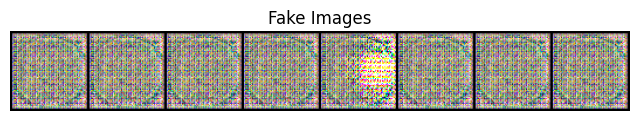

[1451/2000][0/1]	Loss_D: 0.0025	Loss_G: 6.8703	D(x): 0.9988	D(G(z)): 0.0013 / 0.0011
[1452/2000][0/1]	Loss_D: 0.0024	Loss_G: 6.8681	D(x): 0.9990	D(G(z)): 0.0014 / 0.0011
[1453/2000][0/1]	Loss_D: 0.0022	Loss_G: 7.1090	D(x): 0.9990	D(G(z)): 0.0013 / 0.0010
[1454/2000][0/1]	Loss_D: 0.0020	Loss_G: 7.1501	D(x): 0.9990	D(G(z)): 0.0010 / 0.0009
[1455/2000][0/1]	Loss_D: 0.0031	Loss_G: 6.9088	D(x): 0.9991	D(G(z)): 0.0022 / 0.0012
[1456/2000][0/1]	Loss_D: 0.0017	Loss_G: 7.6323	D(x): 0.9988	D(G(z)): 0.0006 / 0.0005
[1457/2000][0/1]	Loss_D: 0.0020	Loss_G: 7.2417	D(x): 0.9989	D(G(z)): 0.0009 / 0.0008
[1458/2000][0/1]	Loss_D: 0.0014	Loss_G: 7.6993	D(x): 0.9991	D(G(z)): 0.0005 / 0.0005
[1459/2000][0/1]	Loss_D: 0.0020	Loss_G: 7.1189	D(x): 0.9992	D(G(z)): 0.0012 / 0.0010
[1460/2000][0/1]	Loss_D: 0.0037	Loss_G: 6.8358	D(x): 0.9993	D(G(z)): 0.0029 / 0.0013
[1461/2000][0/1]	Loss_D: 0.0049	Loss_G: 7.0464	D(x): 0.9988	D(G(z)): 0.0037 / 0.0010
[1462/2000][0/1]	Loss_D: 0.0054	Loss_G: 6.5748	D(x): 0.9970	D(G(z

In [49]:
##Training##

# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = noise#torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

if __name__=='__main__':
    print("Starting Training Loop...")
    #netG.load_state_dict(torch.load('/kaggle/input/gan-major-study-weights2000/generator.weight'))#,map_location=torch.device('cpu')
    #netD.load_state_dict(torch.load('/kaggle/input/gan-major-study-weights2000/discriminator.weight'))#,map_location=torch.device('cpu')
    netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))#,map_location=torch.device('cpu')
    netD.load_state_dict(torch.load('/kaggle/working/discriminator.weight'))#,map_location=torch.device('cpu')
    flag=0
    for epoch in range(EPOCH_NUM):
        for i, data in enumerate(D_inputs, 0):
            # (1) Update the discriminator with real data
            netD.zero_grad()
            # Format batch
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
            #print(b_size)

            label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
            #print('real_label: ',label.shape)
            
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            #print(output.shape)

            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward(retain_graph=True)
            D_x = output.mean().item()

            # (2) Update the discriminator with fake data
            
            # Generate batch of latent vectors
            #noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
            
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(FAKE_LABEL)
            #print('fake_label: ',label.shape)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward(retain_graph=True)
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            # (3) Update the generator with fake data
            netG.zero_grad()
            label.fill_(REAL_LABEL)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward(retain_graph=True)
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, EPOCH_NUM, i, len(D_inputs),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
        if ((epoch+1)%5==0):
            avg_G_Loss=sum(G_losses[-5:])/5
            avg_D_Loss=sum(D_losses[-5:])/5
            if avg_G_Loss>=40 or avg_D_Loss>=5:
                print('Exited')
                break
        
        if ((epoch+1)%50==0):
            print("........Saving.......")
            torch.save(netG.state_dict(), '/kaggle/working/generator.weight')
            torch.save(netD.state_dict(), '/kaggle/working/discriminator.weight')
            with torch.no_grad():
                fake = netG(noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            # Plot some fake images
            real_batch = next(iter(img_list))
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Fake Images")
            plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

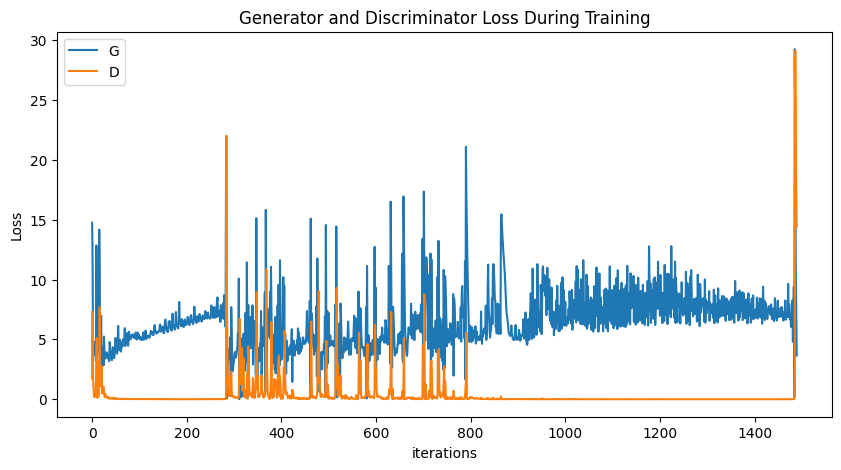

In [50]:
#plot loss graph

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.Size([8, 100, 1, 1])


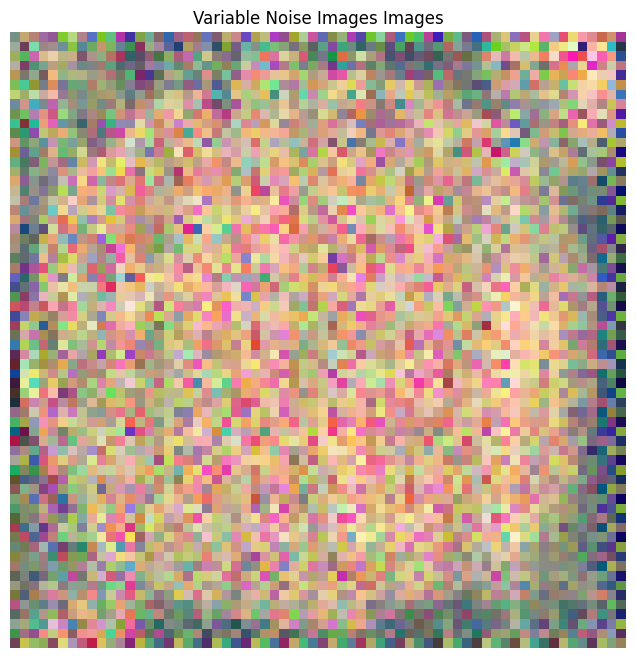

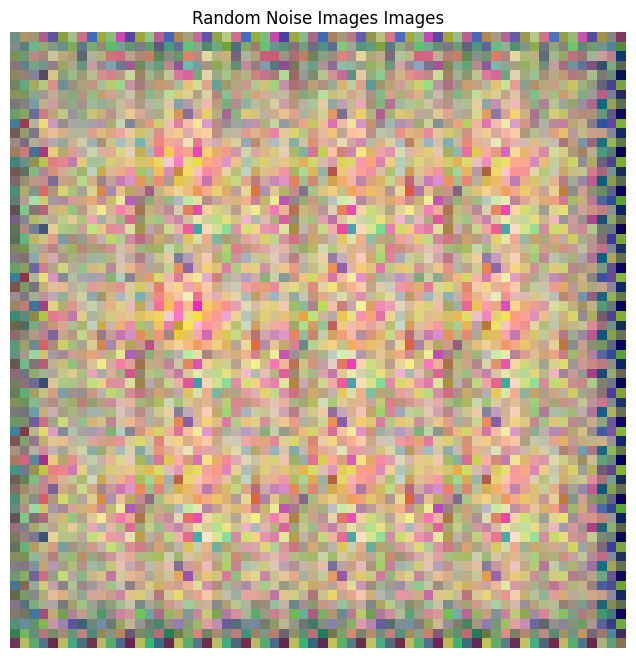

In [51]:
# Generate image

def display_image(dataloader,str):
    # Plot some training images
    Data=dataloader #next(iter(dataloader))
    #print(Data)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"{str} Images")
    plt.imshow(np.transpose(vutils.make_grid(Data[3],nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show() 
    
if __name__=='__main__':
    netG = generator()
    #netG.load_state_dict(torch.load('/kaggle/input/weights/generator.weight'))#,map_location=torch.device('cpu')
    netG.load_state_dict(torch.load('/kaggle/working/generator.weight'))
    netG.to(device)
    rand_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)
    
    with torch.no_grad():
        print(noise.shape)
        fake = netG(noise).detach().cpu()
        rand_fake = netG(rand_noise).detach().cpu()
        #print(fake[0].shape)
    
    #Show Training Images
    display_image(fake,'Variable Noise Images')
    display_image(rand_fake,'Random Noise Images')